In [53]:
# Import libraries
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Load teachers metadata
teachers = pd.read_csv('C:\\Users\LIPSITA_SENAPATI\Desktop\TEACHERS.csv', low_memory=False)


# Print the first three rows
teachers.head(3)

,Teacher,vote_average,vote_count,id,specialisation,sp
0,A,7.7,5415,862,c,1
1,B,6.9,2413,8844,python,2
2,C,6.5,92,15602,java,3


In [54]:
# Load ratings data
ratings = pd.read_csv(r'C:/Users/LIPSITA_SENAPATI/Documents/ratings.csv', low_memory=False)
max_teacher_id = ratings['id'].drop_duplicates().max()
max_specialisation_id = ratings['sp'].drop_duplicates().max()


# Print the first three rows
ratings.head(3)

,id,sp,vote_average
0,862,1,7.7
1,8844,2,6.9
2,15602,3,6.5


In [55]:
# Load specialisation metadata
specialisation = pd.read_csv('C:\\Users\LIPSITA_SENAPATI\Desktop\specialisation.csv', low_memory=False)


# Print the first three rows
specialisation.head(3)

,specialisation,sp
0,c,1
1,python,2
2,java,3


In [56]:
n_teachers = teachers.id.unique().shape[0]
n_specialisation = teachers.sp.unique().shape[0]
print ('Number of teachers = ' + str(n_teachers) + ' | Number of specialisation = ' + str(n_specialisation))

Number of teachers = 26 | Number of specialisation = 7


In [57]:
teachers.user_id = teachers.id.astype('category').cat.codes.values
teachers.item_id = teachers.sp.astype('category').cat.codes.values

In [58]:
teachers.head()

,Teacher,vote_average,vote_count,id,specialisation,sp
0,A,7.7,5415,862,c,1
1,B,6.9,2413,8844,python,2
2,C,6.5,92,15602,java,3
3,D,6.1,34,31357,c++,4
4,E,5.7,173,11862,c++,4


In [59]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(teachers, test_size=0.2)

In [60]:
train.head()

,Teacher,vote_average,vote_count,id,specialisation,sp
21,V,6.5,199,1710,java,3
15,P,7.8,1343,524,c++,4
3,D,6.1,34,31357,c++,4
25,Z,7.0,33,16420,python,2
13,N,7.1,72,10858,java,3


In [61]:
test.head()

,Teacher,vote_average,vote_count,id,specialisation,sp
16,Q,7.2,364,4584,scala,6
7,H,5.4,45,45325,ruby,5
5,F,7.7,1886,949,java,3
0,A,7.7,5415,862,c,1
2,C,6.5,92,15602,java,3


In [62]:
import keras
from keras.layers import merge
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_teacher, n_specialisation = len(teachers.id.unique()), len(teachers.sp.unique())


In [63]:
n_latent_factors_specialisation = 5
n_latent_factors_teacher = 8

teacher_input = keras.layers.Input(shape=[1],name='teacher')
teacher_embedding = keras.layers.Embedding(n_teacher+ 1, n_latent_factors_teacher, name='teacher-Embedding')(teacher_input)
teacher_vec = keras.layers.Flatten(name='FlattenMovies')(teacher_embedding)
teacher_vec = keras.layers.Dropout(0.2)(teacher_vec)


specialisation_input = keras.layers.Input(shape=[1],name='specialisation')
specialisation_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_specialisation + 1, n_latent_factors_specialisation,name='specialisation-Embedding')(specialisation_input))
specialisation_vec = keras.layers.Dropout(0.2)(specialisation_vec)


concat = keras.layers.concatenate([teacher_vec, specialisation_vec], axis=-1)
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([specialisation_input, teacher_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

In [64]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
teacher (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
specialisation (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
teacher-Embedding (Embedding)   (None, 1, 8)         216         teacher[0][0]                    
__________________________________________________________________________________________________
specialisation-Embedding (Embed (None, 1, 5)         40          specialisation[0][0]             
__________________________________________________________________________________________________
FlattenMov

In [65]:
history = model.fit([train.id, train.sp], train.vote_average, epochs=100, verbose=0)

Text(0,0.5,'Train Error')

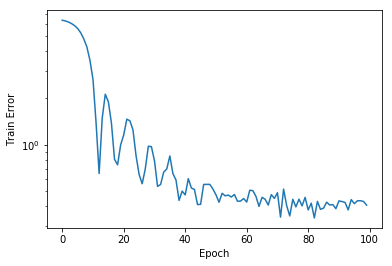

In [66]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [67]:
from sklearn.metrics import mean_absolute_error
y_hat_2 = np.round(model.predict([test.id, test.sp]),0)
y_true = test.vote_average
print(mean_absolute_error(y_true, y_hat_2))

print(mean_absolute_error(y_true, model.predict([test.id, test.sp])))

0.7666666666666667
0.7079735755920411
